# Tutorial 1 at NTU: Financial Forensics

## 0. Introduction

In the following tutorials, we will be using Python. 

But if you don't know Python, you will still be able to grasp my ideas.

Please do raise questions anytime!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

## 1. Benford's Law

Benford’s law states that generally, in naturally occurring collections of numbers, the leading digit
is likely to be small. 

This means that the numeral $1$ will be the leading digit in a dataset around $30 \%$
percent of the time.

The numeral $2$ will be the leading digit $17.6 \%$ of the time, 

and each subsequent
numeral, $3$ through $9$, will be the leading digit with decreasing frequency.

\
Mathematically:

\begin{align*}
    P(d_1(x) = n_1) &= \log_{10}(1 + \frac{1}{n_1}) \qquad & \text{for } n_1 = 1, 2, \dots, 9 \\
    P(d_2(x) = n_2) & = \sum_{n_1=1}^9 \log_{10}({1 + \frac{1}{10 * n_1 + n_2}}) \qquad & \text{for } n_2 = 0, 1, \dots, 9
\end{align*}

In [2]:
n_1 = np.arange(1, 10)
n_2 = np.arange(0, 10)

prob_d1 = np.log10(1 + 1 / n_1)
prob_d1 = pd.Series(prob_d1, index=n_1, name='n_1')

n1_n2 = 10 * n_1[:, None] + n_2[None, :]
prob_d2 = np.log10(1 + 1 / n1_n2).sum(axis=0)
prob_d2 = pd.Series(prob_d2, index=n_2, name='n_2')

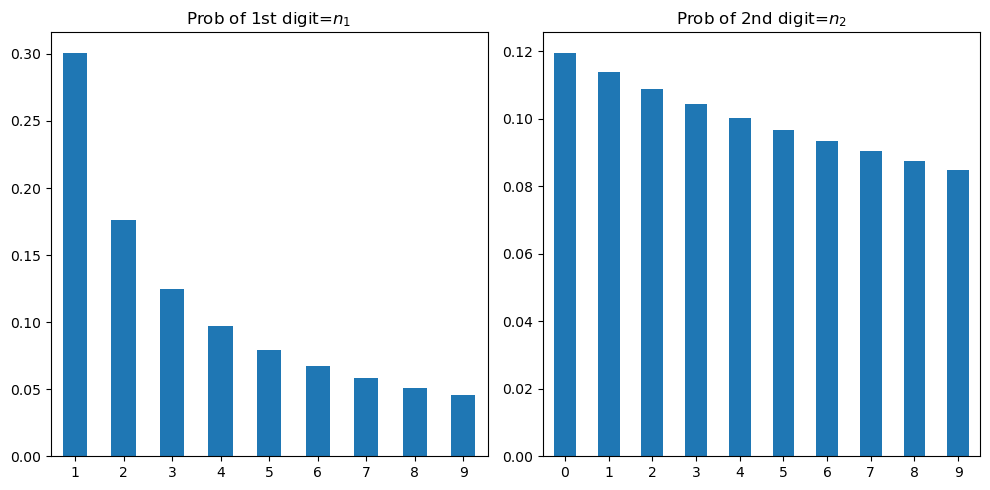

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob_d1.plot.bar(title='Prob of 1st digit=$n_1$', ax=ax[0]);
prob_d2.plot.bar(title='Prob of 2nd digit=$n_2$', ax=ax[1]);

ax[0].tick_params(axis='x', rotation=0)
ax[1].tick_params(axis='x', rotation=0)
fig.tight_layout()
plt.show()

As we can see, for the 2nd digit, the distribution already appears a lot more even.

So, we can expect that from 3rd digit and onwards, there isn't a significant difference.

## 2. Explanation

The simplest explanation is that it was discovered that the fractional part of $\log_{10}(x)$ is <b>uniformly distributed</b> on $[0, 1]$.

And we know that if $d_1(x) = n_1$, then fractional part of $\log_{10}(x)$ is simply:

\begin{align*}
    frac[\log_{10}(x)] & = \log_{10}(x) - \lfloor \log_{10} x \rfloor  \\
    & = \log_{10} (\frac{x}{10 ^ {\lfloor \log_{10} x \rfloor}}) \\
    & \in [\log_{10}(n_1), \log_{10}(n_1 + 1))
\end{align*}

Therefore, 

\begin{align*}
    \mathbb{P}(d_1(x) = n_1) & = \mathbb{P}(frac[\log_{10}(x)] \in [\log_{10}(n_1), \log_{10}(n_1 + 1)]) \\ 
    & = \log_{10}(n_1 + 1) - \log_{10}(n_1) \\
    & = \log_{10}(1 + \frac{1}{n_1})
\end{align*}


Since this observation is based on log-scale, Benford's Law works best when our data has a wide range.

In financial application, market capitalization of stocks and housing prices should follow Benford's Law.

# 3. Hypothesis Testing

<u>Chi-squared Goodness of Fit</u>

For $n$ samples with $K$ categories, where $K$ are the digits in our case:

\begin{equation*}
    \sum_{i=1}^K \frac{(O_i - E_i)^2}{E_i} \xrightarrow{d} \chi^2_{K-1},
\end{equation*}

where $O_i$ is the observed count in category $i$ and $E_i$ is the theoretical count in category $i$.

$E_i$ should equal to $n \times P(d(x) =i)$ in our case.

Therefore, we reject the null hypothesis that the data follows Benford's Law when p-value is large.

# 4. Exercise on Fraud Detection

An investigator analyzed the leading digits from 774 checks issued by seven suspect companies. 

The frequencies were found to be $[222, 151, 80, 77, 66, 57, 48, 35, 38]$, 

and those digits correspond to the leading digits of $1$ to $9$, respectively. 

\
If the observed frequencies are substantially different from their frequencies expected with Benford’s law, 

the check amounts appear to result from fraud. 

\
Use a $10 \%$ significance level to test for the leading digit's goodness of fit with Benford’s law. 
    
Does it appear that the checks are the result of fraud?

### 4.1 Solution

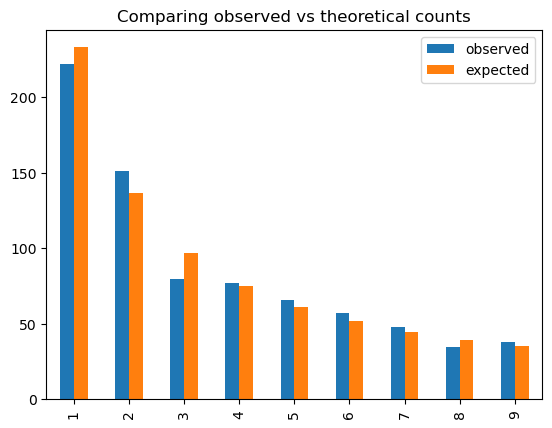

In [4]:
observed = pd.Series([222, 151, 80, 77, 66, 57, 48, 35, 38], index=n_1)
n = np.sum(observed)
k = len(n_1)
expected = prob_d1 * n

count_compare = pd.DataFrame({'observed': observed, 'expected': expected})
count_compare.plot.bar(title='Comparing observed vs theoretical counts');

We can see that the observed frequencies are in fact quite close to the theoretical ones.

Let's try to rigorously prove it using statistical tests!

In [5]:
chisq_stat = ((observed - expected) ** 2 / expected).sum()
chisq_stat

6.861626345163577

In [6]:
# p-value = P(chisq(df=k-1) > chisq_stat)
pval = 1 - chi2.cdf(chisq_stat, df=k-1)
pval

0.5516332364628906

Since p-value $= 55\% > 10\%$, we cannot claim that there are frauds.